# Week 5 - Ridge regression

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt


We will implement Ridge Regression, which is Linear Regression with L2 regularization. We will use the closed-form solution to find the optimal weights.  

The loss function for Ridge Regression is given by:  

$$
J(\mathbf{w}) = ||\mathbf{Xw} - \mathbf{y}||^2 + \lambda ||\mathbf{w}||^2
$$  

The L2 regularization term limits the growth of the weights, preventing overfitting.

In [5]:

class RidgeRegression:
    """
    Kernel Ridge Regression model.

    Attributes:
        ridge (float): Regularization parameter.
        N (int): Number of samples.
        Ky (numpy.ndarray): Coefficients of the fitted model.
        fit_mean (bool): Whether to fit the mean of the data.
        mean_y (float or numpy.ndarray): Mean of the target variable.
        mean_K (float or numpy.ndarray): Mean of the kernel matrix.
    """
    def __init__(self, ridge=0.0, fit_mean=False):
        """
        Initializes the KernelRidgeRegression model with specified parameters.

        Args:
            ridge (float, optional): Regularization parameter. Defaults to 0.0.
            fit_mean (bool, optional): Whether to fit the mean of the data. Defaults to False.
        """
        self.ridge = ridge
        self.N = None
        self.w = None
        self.fit_mean = fit_mean
    
    def fit(self, X, y):
        """
        Fits the model to the training data.

        Args:
            X (numpy.ndarray): Training feature design matrix.
            y (numpy.ndarray): Target variable.

        Notes:
            The method computes the coefficients of the model using the provided kernel matrix and target variable.
        """
        if self.fit_mean:
            self.mean_y = y.mean(0)
            self.mean_X = X.mean(0)
            X = X - self.mean_X[np.newaxis,:]
            y = y - self.mean_y
        else:
            self.mean_y = 0.0
        self.N = X.shape[0]
        XX = X.T @ X + np.eye(X.shape[1]) * self.ridge
        Xy = X.T @ y
        self.w = np.linalg.lstsq(XX, Xy)[0]
    
    def pred(self, X_star):
        """
        Predicts target variable for new data.

        Args:
            X_star (numpy.ndarray): Feature design matrix for new data.

        Returns:
            numpy.ndarray: Predicted target variable.
        """
        if self.fit_mean:
            X_star = X_star - self.mean_X[np.newaxis,:]
        return X_star @ self.w + self.mean_y
    
    def mse(self, X, y):
        """
        Computes mean squared error.

        Args:
            X (numpy.ndarray): Feature design matrix.
            y (numpy.ndarray): Target variable.

        Returns:
            float: Mean squared error.
        """
        y_pred = self.pred(X)
        residual = y - y_pred
        return np.mean(residual * residual)
    
    def score(self, X, y):
        """
        Computes the score of the model.

        Args:
            X (numpy.ndarray): Feature design matrix.
            y (numpy.ndarray): Target variable.

        Returns:
            float: Score of the model.
        """
        return self.mse(X=X, y=y)


In [6]:
def load_temperature_data(year = None):
    """
    load data from a weather station in Potsdam
    
    """

    names = ['station', 'date' , 'type', 'measurement', 'e1','e2', 'E', 'e3']
    data = pd.read_csv('../datasets/weatherstations/GM000003342.csv', names = names)
    # convert the date column to datetime format
    data['date'] = pd.to_datetime(data['date'], format="%Y%m%d") # 47876 unique days
    types = data['type'].unique()

    tmax = data[data['type']=='TMAX'][['date','measurement']] # Maximum temperature (tenths of degrees C), 47876
    tmin = data[data['type']=='TMIN'][['date','measurement']] # Minimum temperature (tenths of degrees C), 47876
    prcp = data[data['type']=='PRCP'][['date','measurement']] # Precipitation (tenths of mm), 47876
    snwd = data[data['type']=='SNWD'][['date','measurement']] # Snow depth (mm), different shape
    tavg = data[data['type']=='TAVG'][['date','measurement']] # average temperature, different shape 1386
    arr = np.array([tmax.measurement.values,tmin.measurement.values, prcp.measurement.values]).T 

    df = pd.DataFrame(arr/10.0, index=tmin.date, columns=['TMAX', 'TMIN', 'PRCP']) # compile data in a dataframe and convert temperatures to degrees C, precipitation to mm

    if year is not None:
        # df = df[pd.datetime(year,1,1):pd.datetime(year,12,31)]
        start_date = datetime.datetime(year, 1, 1)
        end_date = datetime.datetime(year, 12, 31)
        df = df[(df.index >= start_date) & (df.index <= end_date)]
    
    df['days'] = (df.index - df.index.min()).days
    return df



/tmp/ipykernel_12457/1572272376.py:8: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../datasets/weatherstations/GM000003342.csv', names = names)


training MSE : 110.4635
test MSE     : 93.6783


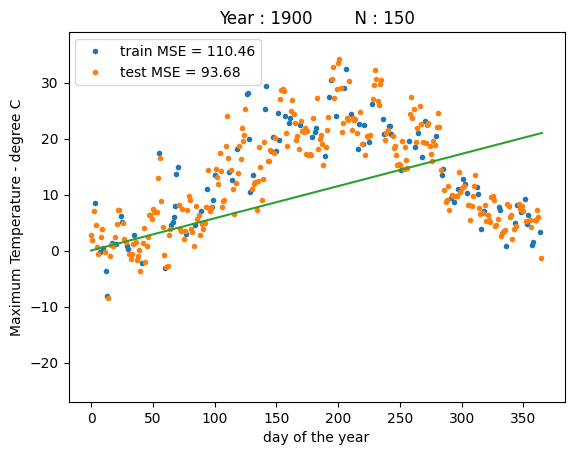

In [7]:

year = 1900
df = load_temperature_data(year = year)


np.random.seed(2)
idx = np.random.permutation(df.shape[0])

idx_train = idx[0:100]
idx_test = idx[100:]

data_train = df.iloc[idx_train]
data_test = df.iloc[idx_test]

fit_mean = False     # fit a separate mean for y in the linear regression? 
ridge = 0     # strength of the L2 penalty in ridge regression

def plot_regression(N_train = 10):
    x_train = data_train.days.values[:N_train][:,np.newaxis] * 1.0
    y_train = data_train.TMAX.values[:N_train]

    reg = RidgeRegression(fit_mean=fit_mean, ridge=ridge)
    reg.fit(x_train, y_train)

    x_days = np.arange(366)[:,np.newaxis]
    y_days_pred = reg.pred(x_days)

    x_test = data_test.days.values[:,np.newaxis] * 1.0
    y_test = data_test.TMAX.values
    y_test_pred = reg.pred(x_test)
    print("training MSE : %.4f" % reg.mse(x_train, y_train))
    print("test MSE     : %.4f" % reg.mse(x_test, y_test))

    
    fig = plt.figure()
    plt.plot(x_train,y_train,'.')
    plt.plot(x_test,y_test,'.')
    plt.legend(["train MSE = %.2f" % reg.mse(x_train, y_train),"test MSE = %.2f" % reg.mse(x_test, y_test)])
    plt.plot(x_days,y_days_pred)
    plt.ylim([-27,39])
    plt.xlabel("day of the year")
    plt.ylabel("Maximum Temperature - degree C")
    plt.title("Year : %i        N : %i" % (year, N_train))
    
    return (fig, reg)
N = 150
fig, reg = plot_regression(N)
plt.show()

# Kernel ridge regression

describe what kernel is
$$
k(\mathbf{x}, \mathbf{x'}) = \phi(\mathbf{x})^\top \phi(\mathbf{x'})
$$


The linear model prediction takes the form:
$$
\mathbf{y} = \mathbf{w^\top}\phi(\mathbf{x})
$$
where $\phi(\mathbf{x})$ is the feature mapping function.


The equivalent kernel form of the linear model is given by:
$$
\mathbf{y} = \mathbf{w^\top} \phi(\mathbf{x}) = \mathbf{k}(\mathbf{x}^\top)(\mathbf{K} + \lambda \mathbf{I})^{-1}\mathbf{t} 
$$

where
$$
\mathbf{K_{nm}} = \phi(\mathbf{x_n})^\top \phi(\mathbf{x_m}) = k(\mathbf{x_n}, \mathbf{x_m})
$$
and $\mathbf{k}(\mathbf{x})$ is the vector with elements $k_n(\mathbf{x}) = k(\mathbf{x_n}, \mathbf{x})$.

Note that unlike in the linear regression there is no training involved. Instead to make predictions you need a datapoints that are used in prediction.

That formulation of kernel ridge regression gives us a lot of flexibility in modeling complex relationships in the data, allowing us to capture non-linear patterns effectively. 
Just by substituting the kernel kernel $k(\mathbf{x}, \mathbf{x'})$  we can use the same closed form solution for different expresivenes


The Ridge regression can be expressed in terms of kernel functions. The kernelized version give the ability to use different kernels allowing to increase the expressivenes of the model.
We will use the closed form solution to find the optimal weights. The use of kernel functions allows us to learn a non-linear function. In this notebook, we will also explore the implementation details and visualize the results.


We implement the following kernels:
- Linear kernel
- Polynomial kernel
- Minkowski kernel
- Squared exponential kernel


In [1]:
import numpy as np
from scipy.spatial import distance_matrix

class Standardizer:
    """
    Standardizes the input data.

    Attributes:
        zero_mean (bool): Whether to center the data to have zero mean.
        unit_variance (bool): Whether to scale the data to have unit variance.
        mean (numpy.ndarray): Mean of each feature.
        standard_deviation (numpy.ndarray): Standard deviation of each feature.
    """
    def __init__(self, zero_mean=True, unit_variance=True):
        self.zero_mean = zero_mean
        self.unit_variance = unit_variance
        self.mean = 0
        self.standard_deviation = 1
    
    def fit(self, X):
        """
        Fits the standardizer to the input data.

        Args:
            X (numpy.ndarray): Input data.
        """
        if self.zero_mean:
            self.mean = X.mean(0)
        else:
            self.mean = np.zeros(X.shape[1])
        if self.unit_variance:
            self.standard_deviation = X.std(0)
        else:
            self.standard_deviation = np.ones(X.shape[1])
    
    def transform(self, X):
        """
        Transforms the input data using the fitted standardizer.

        Args:
            X (numpy.ndarray): Input data.

        Returns:
            numpy.ndarray: Transformed data.
        """
        return (X-self.mean[np.newaxis,:]) / self.standard_deviation[np.newaxis,:]
    
    def reverse_transform(self, X):
        """
        Reverse transforms the standardized data to the original scale.

        Args:
            X (numpy.ndarray): Standardized data.

        Returns:
            numpy.ndarray: Reverse transformed data.
        """
        return (X * self.standard_deviation[np.newaxis,:]) + self.mean[np.newaxis,:]


class MinkowskiExponentialKernel:
    """
    Minkowski Exponential Kernel function.

    Attributes:
        scale (float): Scaling factor for the kernel.
        length_scale (float): Length scale parameter.
        p (float): Exponent for the Minkowski distance.
        standardizer (Standardizer): Standardizer instance for preprocessing data.
        X (numpy.ndarray): Standardized input data.
    """
    def __init__(self, scale=1.0, length_scale=1.0, p=1.0, zero_mean=False, unit_variance=False):
        self.scale = scale
        self.length_scale = length_scale
        self.p = p
        self.standardizer = Standardizer(zero_mean=zero_mean, unit_variance=unit_variance)
    
    def fit(self, X):
        """
        Fits the kernel to the input data.

        Args:
            X (numpy.ndarray): Input data.
        """
        self.standardizer.fit(X)
        self.X = self.standardizer.transform(X)
        
    def transform(self, X_star):
        """
        Transforms new data using the kernel.

        Args:
            X_star (numpy.ndarray): New data to be transformed.

        Returns:
            numpy.ndarray: Transformed data.
        """
        X_star = self.standardizer.transform(X_star)
        distancematrix = distance_matrix(X_star, self.X, self.p)
        K = self.scale * np.exp(-np.power(distancematrix,self.p)/self.length_scale)
        return K

class SquaredExponentialKernel:
    """
    Squared Exponential Kernel function.

    Attributes:
        scale (float): Scaling factor for the kernel.
        length_scale (float): Length scale parameter.
        standardizer (Standardizer): Standardizer instance for preprocessing data.
        X (numpy.ndarray): Standardized input data.
        norm2_X (numpy.ndarray): Squared norms of the input data.
    """
    def __init__(self, scale=1.0, length_scale=1.0, zero_mean=False, unit_variance=False):
        self.scale = scale
        self.length_scale = length_scale
        self.standardizer = Standardizer(zero_mean=zero_mean, unit_variance=unit_variance)
    
    def fit(self, X):
        """
        Fits the kernel to the input data.

        Args:
            X (numpy.ndarray): Input data.
        """
        self.standardizer.fit(X)
        self.X = self.standardizer.transform(X)
        self.norm2_X = (X*X).sum(1)

    def transform(self, X_star):
        """
        Transforms new data using the kernel.

        Args:
            X_star (numpy.ndarray): New data to be transformed.

        Returns:
            numpy.ndarray: Transformed data.
        """
        X_star = self.standardizer.transform(X_star)
        XX = X_star @ self.X.T
        norm2_X_star = (X_star*X_star).sum(1)
        K = self.scale * np.exp((XX - 0.5 * self.norm2_X[np.newaxis,:] - 0.5 * norm2_X_star[:,np.newaxis])/self.length_scale)
        return K

class PolynomialKernel:
    """
    Polynomial Kernel function.

    Attributes:
        constant (float): Constant term in the polynomial.
        degree (float): Degree of the polynomial.
        standardizer (Standardizer): Standardizer instance for preprocessing data.
        X (numpy.ndarray): Standardized input data.
    """
    def __init__(self, constant=1.0, degree=1.0, zero_mean=False, unit_variance=False):
        self.constant = constant
        self.degree = degree
        self.standardizer = Standardizer(zero_mean=zero_mean, unit_variance=unit_variance)
    
    def fit(self, X):
        """
        Fits the kernel to the input data.

        Args:
            X (numpy.ndarray): Input data.
        """
        self.standardizer.fit(X=X)
        self.X = self.standardizer.transform(X=X)
        
    def transform(self, X_star):
        """
        Transforms new data using the kernel.

        Args:
            X_star (numpy.ndarray): New data to be transformed.

        Returns:
            numpy.ndarray: Transformed data.
        """
        X_star = self.standardizer.transform(X_star)
        XX = X_star @ self.X.T
        
        K = np.power(XX + self.constant, self.degree)
        if (self.degree % 1.0): # for non-integer degrees, we could have NaNs in the Kernel
            K[K!=K] = 0.0
        return K

class LinearKernel:
    """
    Linear Kernel function.

    Attributes:
        standardizer (Standardizer): Standardizer instance for preprocessing data.
        X (numpy.ndarray): Standardized input data.
    """
    def __init__(self, zero_mean=True, unit_variance=True):
        self.standardizer = Standardizer(zero_mean=zero_mean, unit_variance=unit_variance)
        self.X = None

    def fit(self, X):
        """
        Fits the kernel to the input data.

        Args:
            X (numpy.ndarray): Input data.
        """
        self.standardizer.fit(X=X)
        self.X = self.standardizer.transform(X=X)

    def transform(self,X_star):
        """
        Transforms new data using the kernel.

        Args:
            X_star (numpy.ndarray): New data to be transformed.

        Returns:
            numpy.ndarray: Transformed data.
        """
        X_star = self.standardizer.transform(X_star)
        return X_star @ self.X.T


In [7]:
class KernelRidgeRegression:
    """
    Kernel Ridge Regression model.

    Attributes:
        ridge (float): Regularization parameter.
        N (int): Number of samples.
        Ky (numpy.ndarray): Coefficients of the fitted model.
    """
    def __init__(self, ridge=0.0):
        """
        Initializes the KernelRidgeRegression model with specified parameters.

        Args:
            ridge (float, optional): Regularization parameter. Defaults to 0.0.
        """
        self.ridge = ridge
        self.N = None
        self.Ky = None
    
    def fit(self, K, y):
        """
        Fits the model to the training data.

        Args:
            K (numpy.ndarray): Kernel matrix.
            y (numpy.ndarray): Target variable.

        Notes:
            The method computes the coefficients of the model using the provided kernel matrix and target variable.
        """
        self.N = K.shape[0]
        KI = K + np.eye(self.N) * self.ridge
        self.Ky = np.linalg.lstsq(KI, y)[0]
    
    def pred(self, K_star):
        """
        Predicts target variable for new data.

        Args:
            K_star (numpy.ndarray): Kernel matrix for new data.

        Returns:
            numpy.ndarray: Predicted target variable.
        """
        prediction = K_star @ self.Ky
        return prediction
    
    def mse(self, K, y):
        """
        Computes mean squared error.

        Args:
            K (numpy.ndarray): Kernel matrix.
            y (numpy.ndarray): Target variable.

        Returns:
            float: Mean squared error.
        """
        y_pred = self.pred(K)
        residual = y - y_pred
        return np.mean(residual * residual)
    
    def score(self, K, y):
        """
        Computes the score of the model.

        Args:
            K (numpy.ndarray): Kernel matrix.
            y (numpy.ndarray): Target variable.

        Returns:
            float: Score of the model.
        """
        return self.mse(K=K, y=y)


/tmp/ipykernel_28375/1107551213.py:8: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../datasets/weatherstations/GM000003342.csv', names = names)


training MSE : 12.9548
test MSE     : 17.0264


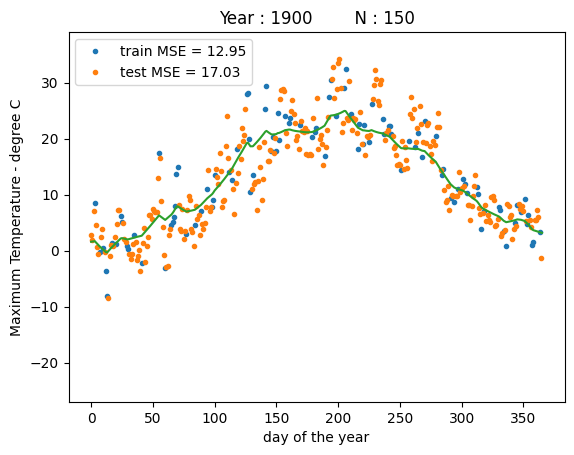

In [8]:
year = 1900
df = load_temperature_data(year = year)


np.random.seed(2)
idx = np.random.permutation(df.shape[0])

idx_train = idx[0:100]
idx_test = idx[100:]

data_train = df.iloc[idx_train]
data_test = df.iloc[idx_test]

unit_variance = False   # standardize X to be 1 variance for each feature?
zero_mean = True    # standardize X to be 0 mean for each feature?

ridge = 1.0     # strength of the L2 penalty in ridge regression
if 0:
    kernel = LinearKernel(unit_variance=unit_variance, zero_mean=zero_mean)
elif 0:
    kernel = SquaredExponentialKernel(scale=1.0, length_scale=200.0, unit_variance=unit_variance, zero_mean=zero_mean)
elif 0:
    # The polynomial kernel seems to be numerically very unstable for large degrees
    kernel = PolynomialKernel(constant=1.0, degree=2.0, unit_variance=unit_variance,zero_mean=zero_mean)
elif 1:
    kernel = MinkowskiExponentialKernel(scale=1.0, length_scale=50.0, p=1.0, unit_variance=unit_variance, zero_mean=zero_mean)


def plot_regression(N_train = 10):
    x_train = data_train.days.values[:N_train][:,np.newaxis] * 1.0
    y_train = data_train.TMAX.values[:N_train]


    reg = KernelRidgeRegression(ridge=ridge)
    kernel.fit(X=x_train)
    K_train = kernel.transform(X_star=x_train)
    reg.fit(K_train, y_train)

    x_days = np.arange(366)[:,np.newaxis]
    K_days = kernel.transform(X_star = x_days)
    y_days_pred = reg.pred(K_days)

    x_test = data_test.days.values[:,np.newaxis] * 1.0
    K_test = kernel.transform(X_star = x_test)
    y_test = data_test.TMAX.values
    y_test_pred = reg.pred(K_test)
    print("training MSE : %.4f" % reg.mse(K_train, y_train))
    print("test MSE     : %.4f" % reg.mse(K_test, y_test))

    
    fig = plt.figure()
    plt.plot(x_train,y_train,'.')
    plt.plot(x_test,y_test,'.')
    plt.legend(["train MSE = %.2f" % reg.mse(K_train, y_train),"test MSE = %.2f" % reg.mse(K_test, y_test)])
    plt.plot(x_days,y_days_pred)
    plt.ylim([-27,39])
    plt.xlabel("day of the year")
    plt.ylabel("Maximum Temperature - degree C")
    plt.title("Year : %i        N : %i" % (year, N_train))
    
    return (fig, reg)
N = 150
fig, reg = plot_regression(N)
plt.show()